# 03 — ML Model for 1EY0A with Structural Features

This notebook trains a Random Forest regression model to predict experimental ΔΔG
for single mutations in protein **1EY0A**, using:

- sequence-derived features (Δhydropathy, Δcharge, Δvolume, Δpolarity, BLOSUM62)
- mutation flags (Gly/Pro indicators)
- structural context from DSSP:
  - secondary structure (`ss_idx`, `ss_H`, `ss_E`, `ss_C`)
  - solvent accessibility (`asa`, `asa_norm`, `is_buried`, `is_exposed`)

Input: `data/processed/features_structural.csv`  
Output:
- trained model: `results/models_structural/rf_structural_1EY0A.pkl`
- metrics: `results/models_structural/metrics_structural_1EY0A.json`
- scatter plot: `results/models_structural/1EY0A_structural_rf_scatter.png`

In [1]:
from pathlib import Path
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# -------------------------------------------------------------------
# Paths (project root = repo root where this notebook lives under /notebooks)
# -------------------------------------------------------------------
PROJECT_ROOT = Path.cwd().parents[0]  # .../protein-multimutant-ranking
DATA_PROCESSED = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results" / "models_structural"

RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)
print("Processed data:", DATA_PROCESSED)
print("Results dir:", RESULTS_DIR)

Project root: /Users/saturnine/Desktop/FALL 2025/Bioinformatics/project/protein-multimutant-ranking
Processed data: /Users/saturnine/Desktop/FALL 2025/Bioinformatics/project/protein-multimutant-ranking/data/processed
Results dir: /Users/saturnine/Desktop/FALL 2025/Bioinformatics/project/protein-multimutant-ranking/results/models_structural


In [2]:
# This file was created by src/feature_engineering.py with --dssp_dir
feats_path = DATA_PROCESSED / "features_structural.csv"
df = pd.read_csv(feats_path)

print("Full structural feature table shape:", df.shape)
df.head()

Full structural feature table shape: (2645, 27)


,clid,pdb_id,chain,wt,res_index,mut,ddg_exp_kcal,pH,temp_C,pos,...,is_to_gly,is_to_pro,ss_idx,ss_H,ss_E,ss_C,asa,asa_norm,is_buried,is_exposed
0,1A43A,1A43,A,C,218.0,S,-3.70,7.3,25.0,218.0,...,0,0,2,0,0,1,NaN,NaN,0,0
1,1A43A,1A43,A,E,159.0,D,-4.55,7.3,25.0,159.0,...,0,0,2,0,0,1,NaN,NaN,0,0
2,1A43A,1A43,A,G,156.0,A,-2.40,7.3,25.0,156.0,...,0,0,2,0,0,1,NaN,NaN,0,0
3,1A43A,1A43,A,R,167.0,A,-4.55,7.3,25.0,167.0,...,0,0,2,0,0,1,NaN,NaN,0,0
4,1A43A,1A43,A,W,184.0,A,-0.70,7.3,25.0,184.0,...,0,0,2,0,0,1,NaN,NaN,0,0


In [3]:
# Filter to one protein: 1EY0A
df_1ey0 = df[df["clid"] == "1EY0A"].copy()
print("1EY0A subset shape:", df_1ey0.shape)

# Quick peek
df_1ey0.head()

1EY0A subset shape: (482, 27)


,clid,pdb_id,chain,wt,res_index,mut,ddg_exp_kcal,pH,temp_C,pos,...,is_to_gly,is_to_pro,ss_idx,ss_H,ss_E,ss_C,asa,asa_norm,is_buried,is_exposed
500,1EY0A,1EY0,A,A,12.0,G,-2.37,7.0,20.0,12.0,...,1,0,0,0,1,0,12.0,0.041096,1,0
501,1EY0A,1EY0,A,A,12.0,V,-0.89,7.0,20.0,12.0,...,0,0,0,0,1,0,12.0,0.041096,1,0
502,1EY0A,1EY0,A,A,17.0,G,0.19,7.0,20.0,17.0,...,1,0,0,0,1,0,14.0,0.047945,1,0
503,1EY0A,1EY0,A,A,17.0,V,-1.94,7.0,20.0,17.0,...,0,0,0,0,1,0,14.0,0.047945,1,0
504,1EY0A,1EY0,A,A,58.0,G,-2.53,7.0,20.0,58.0,...,1,0,1,1,0,0,0.0,0.000000,1,0


In [4]:
TARGET = "ddg_exp_kcal"

# Manually list the numeric features we want to use
numeric_features = [
    # environment
    "pH", "temp_C",
    # sequence deltas
    "delta_hydropathy", "delta_charge",
    "delta_volume", "delta_polarity",
    "blosum62",
    # mutation flags
    "is_gly", "is_pro", "is_to_gly", "is_to_pro",
    # structural features from DSSP
    "ss_idx", "ss_H", "ss_E", "ss_C",
    "asa", "asa_norm", "is_buried", "is_exposed",
]

missing = [c for c in numeric_features if c not in df_1ey0.columns]
print("Missing in df_1ey0:", missing)

X = df_1ey0[numeric_features].values
y = df_1ey0[TARGET].values

print("X shape:", X.shape)
print("y shape:", y.shape)

print("ΔΔG summary:")
print(pd.Series(y).describe())

Missing in df_1ey0: []
X shape: (482, 19)
y shape: (482,)
ΔΔG summary:
count    482.000000
mean      -1.336763
std        1.366589
min       -4.980000
25%       -2.215000
50%       -1.035000
75%       -0.250000
max        1.430000
dtype: float64


In [5]:
RANDOM_STATE = 42

def rmse(y_true, y_pred):
    return float(np.sqrt(mean_squared_error(y_true, y_pred)))

rf = RandomForestRegressor(
    n_estimators=600,
    max_depth=None,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=RANDOM_STATE,
)

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("rf", rf),
])

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

r2_scores = cross_val_score(pipe, X, y, cv=kf, scoring="r2")
rmse_scores = -cross_val_score(pipe, X, y, cv=kf, scoring="neg_root_mean_squared_error")

print("CV R2 scores:", np.round(r2_scores, 3))
print("CV RMSE scores:", np.round(rmse_scores, 3))
print("\nCV R2 mean ± std:  {:.3f} ± {:.3f}".format(r2_scores.mean(), r2_scores.std()))
print("CV RMSE mean ± std: {:.3f} ± {:.3f}".format(rmse_scores.mean(), rmse_scores.std()))

CV R2 scores: [0.36  0.48  0.454 0.509 0.47 ]
CV RMSE scores: [1.147 0.854 1.066 1.042 0.886]

CV R2 mean ± std:  0.455 ± 0.051
CV RMSE mean ± std: 0.999 ± 0.111


In [6]:
# Fit on all 1EY0A data
pipe.fit(X, y)

y_pred = pipe.predict(X)

train_r2 = r2_score(y, y_pred)
train_rmse = rmse(y, y_pred)
train_mae = mean_absolute_error(y, y_pred)

print(f"Train R2:   {train_r2:.3f}")
print(f"Train RMSE: {train_rmse:.3f}")
print(f"Train MAE:  {train_mae:.3f}")

Train R2:   0.823
Train RMSE: 0.575
Train MAE:  0.404


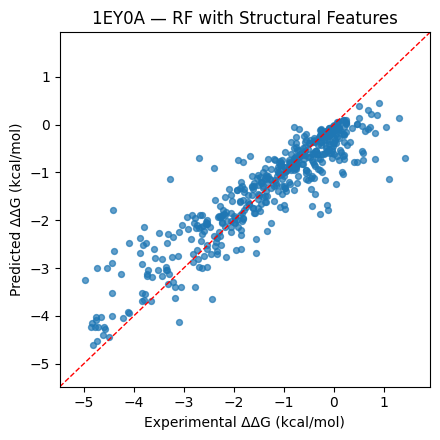

Saved scatter plot to: /Users/saturnine/Desktop/FALL 2025/Bioinformatics/project/protein-multimutant-ranking/results/models_structural/1EY0A_structural_rf_scatter.png


In [7]:
plt.figure(figsize=(4.5, 4.5))
plt.scatter(y, y_pred, s=18, alpha=0.7)
lims = [
    min(y.min(), y_pred.min()) - 0.5,
    max(y.max(), y_pred.max()) + 0.5
]
plt.plot(lims, lims, "r--", linewidth=1)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("Experimental ΔΔG (kcal/mol)")
plt.ylabel("Predicted ΔΔG (kcal/mol)")
plt.title("1EY0A — RF with Structural Features")
plt.tight_layout()

plot_path = RESULTS_DIR / "1EY0A_structural_rf_scatter.png"
plt.savefig(plot_path, dpi=200)
plt.show()

print("Saved scatter plot to:", plot_path)

In [8]:
import joblib

model_path = RESULTS_DIR / "rf_structural_1EY0A.pkl"
joblib.dump(pipe, model_path)

metrics = {
    "protein": "1EY0A",
    "n_samples": int(len(y)),
    "n_features": len(numeric_features),
    "features": numeric_features,
    "cv_r2_mean": float(r2_scores.mean()),
    "cv_r2_std": float(r2_scores.std()),
    "cv_rmse_mean": float(rmse_scores.mean()),
    "cv_rmse_std": float(rmse_scores.std()),
    "train_r2": float(train_r2),
    "train_rmse": float(train_rmse),
    "train_mae": float(train_mae),
}

metrics_path = RESULTS_DIR / "metrics_structural_1EY0A.json"
with open(metrics_path, "w") as f:
    json.dump(metrics, f, indent=2)

print("Saved model →", model_path)
print("Saved metrics →", metrics_path)

Saved model → /Users/saturnine/Desktop/FALL 2025/Bioinformatics/project/protein-multimutant-ranking/results/models_structural/rf_structural_1EY0A.pkl
Saved metrics → /Users/saturnine/Desktop/FALL 2025/Bioinformatics/project/protein-multimutant-ranking/results/models_structural/metrics_structural_1EY0A.json
